In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [4]:
# # generate some training data
n_samples = 220
seq_len = 18

## generate sin wave data with different frequencies
def generate_sin_wave_data(n_samples, seq_len, noise=0.1, seed=42):
    np.random.seed(seed)
    X = []
    y = []
    for i in range(n_samples):
        freq = np.random.uniform(0.1, 1.0)  # frequency between 0.1 and 1.0
        x = np.linspace(0, 6 * np.pi, seq_len)
        seq = np.sin(freq * x) + np.random.normal(0, noise, seq_len)  # add some noise
        X.append(seq)
        y.append(freq)  # target is the frequency
    X = np.array(X).reshape(n_samples, seq_len, 1)  # shape (n_samples, seq_len, 1)
    y = np.array(y).reshape(n_samples, 1)  # shape (n_samples, 1)
    return X, y

X, y_true = generate_sin_wave_data(n_samples, seq_len, noise=0.05)
# normalize X to [0, 1]
X = (X - X.min()) / (X.max() - X.min())
print(f"Generated data shapes: {X.shape}, {y_true.shape}")

Generated data shapes: (220, 18, 1), (220, 1)


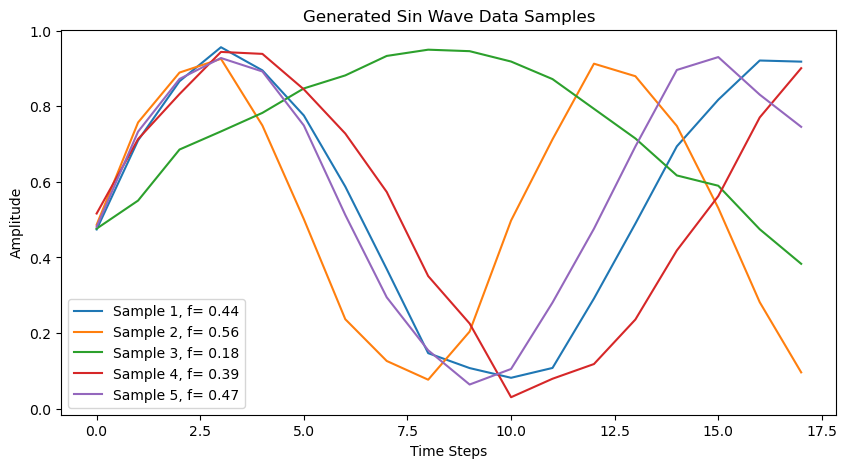

In [5]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X[i].flatten(), label=f"Sample {i+1}, f= {y_true[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [6]:
# train test split
percentage = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, test_size=1 - percentage, random_state=42
)

In [7]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 5),  # =1D kernel size
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0),
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 7.0
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_2"
)
NAHEA_CNN.eval()

Final FC NN: Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)
Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [8]:
# train the model
batch_size = 16
epochs = 20
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
print(f"{NAHEA_CNN.parameters()}")
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
    lr=0.01,
    weight_decay=1e-5,
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = [NAHEA_CNN(xx) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted.squeeze(1), y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1}/{n_samples // batch_size}, Loss: {loss.item()}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss: {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.],
        [ 14.,   0.]], requires_grad=True), 'local_pulses_omega_1': tensor([0.5000, 1.0000, 1.5000, 1.0000, 0.5000], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'global_pulse_omega_1': tensor(1., requires_grad=True), 'global_pulse_delta_1': tensor(0., requires_grad=True), 'global_pulse_omega_2': tensor(0.5000, requires_grad=True), 'global_pulse_delta_2': tensor(0., requires_grad=True), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([0.0037, 0.0278, 0.0352, 0.0563, 0.0591, 0.0438, 0.0324, 0.0473, 0.0866,
        0.0037, 0.0516, 0.0295, 0.0264, 0.0545, 0.0489, 0.0234, 0.0439, 0.0317,
        0.0406, 0.0365, 0.0408, 0.0743, 0.0780, 0.0146, 0.0581, 0.0085, 0.0224,
        0.0388, 0.0235, 0.0435, 0.0476, 0.0823], dtype=torch.float64,
       requires_grad

Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.4248922299380469
Batch 2/13, Loss: 0.26133408902234756
Batch 3/13, Loss: 0.15959917971668305
Batch 4/13, Loss: 0.12881341395099252
Batch 5/13, Loss: 0.06123497762795321
Batch 6/13, Loss: 0.09590919988165096
Batch 7/13, Loss: 0.09641941986522565
Batch 8/13, Loss: 0.13377338723038992
Batch 9/13, Loss: 0.09912400509340835
Batch 10/13, Loss: 0.09663543053294173
Batch 11/13, Loss: 0.05401181281083867
Epoch 1 train loss: 0.14652246778822534


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.054810226509751994
Batch 2/13, Loss: 0.05127529295998911
Batch 3/13, Loss: 0.05579882503026464
Batch 4/13, Loss: 0.07889987117460766
Batch 5/13, Loss: 0.06905157270560536
Batch 6/13, Loss: 0.050124626355270666
Batch 7/13, Loss: 0.03940447949124155
Batch 8/13, Loss: 0.062174328676198085
Batch 9/13, Loss: 0.03607567636921146
Batch 10/13, Loss: 0.06839680312020667
Batch 11/13, Loss: 0.05539843784989197
Epoch 2 train loss: 0.056491830931112645


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.04193818338507815
Batch 2/13, Loss: 0.01728274696035023
Batch 3/13, Loss: 0.05637238457301689
Batch 4/13, Loss: 0.05382627047255107
Batch 5/13, Loss: 0.05105373812304076
Batch 6/13, Loss: 0.04957496886482568
Batch 7/13, Loss: 0.05606315655137434
Batch 8/13, Loss: 0.02903219659368555
Batch 9/13, Loss: 0.03111188748821383
Batch 10/13, Loss: 0.030175483881859866
Batch 11/13, Loss: 0.021325498903238406
Epoch 3 train loss: 0.0397960468906577


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0327370625068906
Batch 2/13, Loss: 0.04251413289080238
Batch 3/13, Loss: 0.037849132488541215
Batch 4/13, Loss: 0.014586282349087296
Batch 5/13, Loss: 0.01779739384651602
Batch 6/13, Loss: 0.015337850452658243
Batch 7/13, Loss: 0.030721154161163458
Batch 8/13, Loss: 0.01488656650177406
Batch 9/13, Loss: 0.01621011226775452
Batch 10/13, Loss: 0.01517754372820311
Batch 11/13, Loss: 0.015952073765968734
Epoch 4 train loss: 0.023069936814487237


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.018377973666688675
Batch 2/13, Loss: 0.008488675429053565
Batch 3/13, Loss: 0.007493702656608864
Batch 4/13, Loss: 0.0052505021747884005
Batch 5/13, Loss: 0.003933258560826021
Batch 6/13, Loss: 0.005946173050219503
Batch 7/13, Loss: 0.014097086742364992
Batch 8/13, Loss: 0.0046587944021826595
Batch 9/13, Loss: 0.014461414117874253
Batch 10/13, Loss: 0.004472345013570801
Batch 11/13, Loss: 0.0034089580325947916
Epoch 5 train loss: 0.008235353076979321


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.003676334425440848
Batch 2/13, Loss: 0.006441609052233819
Batch 3/13, Loss: 0.0061000405315975
Batch 4/13, Loss: 0.0037063319908819583
Batch 5/13, Loss: 0.0018682099763753428
Batch 6/13, Loss: 0.0016913262771698306
Batch 7/13, Loss: 0.0013003165067625598
Batch 8/13, Loss: 0.003332787011209037
Batch 9/13, Loss: 0.0030952105648063603
Batch 10/13, Loss: 0.0019488379093956626
Batch 11/13, Loss: 0.0005532862050466958
Epoch 6 train loss: 0.003064935495538146


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0007288746680127334
Batch 2/13, Loss: 0.0007037949713743806
Batch 3/13, Loss: 0.0011186470751442296
Batch 4/13, Loss: 0.001149679581968078
Batch 5/13, Loss: 0.001731538331043152
Batch 6/13, Loss: 0.00118143074311912
Batch 7/13, Loss: 0.0008001252690351406
Batch 8/13, Loss: 0.0007389002037738175
Batch 9/13, Loss: 0.001051595688052848
Batch 10/13, Loss: 0.0016786080214258878
Batch 11/13, Loss: 0.0009168550231609229
Epoch 7 train loss: 0.0010727317796463917


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0004971749592263229
Batch 2/13, Loss: 0.0005280791051726721
Batch 3/13, Loss: 0.0005116409346416253
Batch 4/13, Loss: 0.0012354405858341765
Batch 5/13, Loss: 0.0009443087032698282
Batch 6/13, Loss: 0.0008243411513148773
Batch 7/13, Loss: 0.0004078685311828884
Batch 8/13, Loss: 0.00040164772155039093
Batch 9/13, Loss: 0.00046280163375602665
Batch 10/13, Loss: 0.0008388777468044658
Batch 11/13, Loss: 0.001049740694551922
Epoch 8 train loss: 0.0007001747061186541


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0004654291538346049
Batch 2/13, Loss: 0.00028578009100325063
Batch 3/13, Loss: 0.0004397228026558936
Batch 4/13, Loss: 0.00045767455800039446
Batch 5/13, Loss: 0.000517971084351764
Batch 6/13, Loss: 0.0004167752028774856
Batch 7/13, Loss: 0.00038759639081552565
Batch 8/13, Loss: 0.00019298908363991833
Batch 9/13, Loss: 0.0005398034850516219
Batch 10/13, Loss: 0.0007264216107530043
Batch 11/13, Loss: 0.0004717912948130148
Epoch 9 train loss: 0.00044563225070877075


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.00031971154140848453
Batch 2/13, Loss: 0.00043210030271093237
Batch 3/13, Loss: 0.0005898144423079303
Batch 4/13, Loss: 0.00040016168826748305
Batch 5/13, Loss: 0.0005696041066782708
Batch 6/13, Loss: 0.0003598661570495103
Batch 7/13, Loss: 0.00025059611453382964
Batch 8/13, Loss: 0.0004093442052009315
Batch 9/13, Loss: 0.00029851383205647735
Batch 10/13, Loss: 0.0006517570866937593
Batch 11/13, Loss: 0.0003567999862961558
Epoch 10 train loss: 0.00042166086029125135


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0005804035151248824
Batch 2/13, Loss: 0.0004702772257937921
Batch 3/13, Loss: 0.0003709699679148443
Batch 4/13, Loss: 0.00027345694255251655
Batch 5/13, Loss: 0.0003804449553781473
Batch 6/13, Loss: 0.0003026579162138043
Batch 7/13, Loss: 0.000252975752412739
Batch 8/13, Loss: 0.0002730644922727721
Batch 9/13, Loss: 0.0005778639924058231
Batch 10/13, Loss: 0.00040535594787470867
Batch 11/13, Loss: 0.00014616074442874602
Epoch 11 train loss: 0.00036669376839752505


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.000349536942789271
Batch 2/13, Loss: 0.0003570059416426571
Batch 3/13, Loss: 0.00044855146962760557
Batch 4/13, Loss: 0.00038682865910487813
Batch 5/13, Loss: 0.00021123980953418388
Batch 6/13, Loss: 0.0004371897346522155
Batch 7/13, Loss: 0.00033694563733057504
Batch 8/13, Loss: 0.00017490243758659405
Batch 9/13, Loss: 0.0003186085058384542
Batch 10/13, Loss: 0.0006073381466952559
Batch 11/13, Loss: 0.0005999390511222028
Epoch 12 train loss: 0.00038437148508399033


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0002786567231271468
Batch 2/13, Loss: 0.00013440047781874888
Batch 3/13, Loss: 0.0005676135548440432
Batch 4/13, Loss: 0.0004916669436540353
Batch 5/13, Loss: 0.00045302776918830934
Batch 6/13, Loss: 0.00042274397354429623
Batch 7/13, Loss: 0.00043601002667806874
Batch 8/13, Loss: 0.0004820014071564917
Batch 9/13, Loss: 0.0008327015124654287
Batch 10/13, Loss: 0.00031476184204681784
Batch 11/13, Loss: 0.0002854145475907396
Epoch 13 train loss: 0.0004271817071012842


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0006087643617504461
Batch 2/13, Loss: 0.00046693650976483277
Batch 3/13, Loss: 0.0003233913586445404
Batch 4/13, Loss: 0.0003040526463137039
Batch 5/13, Loss: 0.00040047775510658045
Batch 6/13, Loss: 0.0006468565410381866
Batch 7/13, Loss: 0.0001667714148680883
Batch 8/13, Loss: 0.00029232596635494427
Batch 9/13, Loss: 0.00031900363358885206
Batch 10/13, Loss: 0.00019648541995350148
Batch 11/13, Loss: 0.0004655955458426814
Epoch 14 train loss: 0.0003809691957478507


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.00021857771637850043
Batch 2/13, Loss: 0.00020125460361396555
Batch 3/13, Loss: 0.00042415941136474784
Batch 4/13, Loss: 0.00030267235675809977
Batch 5/13, Loss: 0.00021598276805737191
Batch 6/13, Loss: 0.00019823234085611195
Batch 7/13, Loss: 0.00022065649882412497
Batch 8/13, Loss: 0.0003015478308323495
Batch 9/13, Loss: 0.0004369633767688085
Batch 10/13, Loss: 0.0006019275301209426
Batch 11/13, Loss: 0.00042416457820964275
Epoch 15 train loss: 0.000322376273798606


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0002969371205207039
Batch 2/13, Loss: 0.00028694558008440356
Batch 3/13, Loss: 0.0005287285134628666
Batch 4/13, Loss: 0.00021278308181175447
Batch 5/13, Loss: 0.0005031357703316779
Batch 6/13, Loss: 0.0002452631020130477
Batch 7/13, Loss: 0.0001449005954576535
Batch 8/13, Loss: 0.00020591749396489068
Batch 9/13, Loss: 0.0001391918574655655
Batch 10/13, Loss: 0.0003623991990006037
Batch 11/13, Loss: 0.00036154749388773083
Epoch 16 train loss: 0.0002988863461818999


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0007341753876882047
Batch 2/13, Loss: 0.0001702205521379831
Batch 3/13, Loss: 0.0002265510416706421
Batch 4/13, Loss: 0.0002498724945990411
Batch 5/13, Loss: 0.0003034067822743979
Batch 6/13, Loss: 0.000388449034183528
Batch 7/13, Loss: 0.0002825003308989789
Batch 8/13, Loss: 0.000309844369073416
Batch 9/13, Loss: 0.0003134241477377572
Batch 10/13, Loss: 0.00015403643210414646
Batch 11/13, Loss: 0.000166068377249555
Epoch 17 train loss: 0.0002998680863288773


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0003301178515001483
Batch 2/13, Loss: 0.0003011426838064489
Batch 3/13, Loss: 0.00031365914454860376
Batch 4/13, Loss: 0.00019011451266677596
Batch 5/13, Loss: 0.00026501743648495277
Batch 6/13, Loss: 0.00025662179638601514
Batch 7/13, Loss: 0.0004919978022837979
Batch 8/13, Loss: 0.0001470698168323105
Batch 9/13, Loss: 0.00040603549270261483
Batch 10/13, Loss: 0.0003402818665673256
Batch 11/13, Loss: 0.000277734753167128
Epoch 18 train loss: 0.00030179937790419286


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.0003076816241522642
Batch 2/13, Loss: 0.00027564149976222816
Batch 3/13, Loss: 0.0006016107049964059
Batch 4/13, Loss: 0.00032493699082120113
Batch 5/13, Loss: 0.0002497948504842634
Batch 6/13, Loss: 0.00026034639508656845
Batch 7/13, Loss: 0.00014951043799975685
Batch 8/13, Loss: 0.0005159217839519571
Batch 9/13, Loss: 0.00023124051282021602
Batch 10/13, Loss: 0.0003640052076132374
Batch 11/13, Loss: 0.00022838988526958042
Epoch 19 train loss: 0.0003190072629961527


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.00020745620052701645
Batch 2/13, Loss: 0.00017462867961747888
Batch 3/13, Loss: 0.0002705030257544984
Batch 4/13, Loss: 0.00023985545467577644
Batch 5/13, Loss: 0.00020128571579020342
Batch 6/13, Loss: 0.0001694761349641766
Batch 7/13, Loss: 0.00025849329609219844
Batch 8/13, Loss: 0.0004911980763037192
Batch 9/13, Loss: 0.00044290395095125353
Batch 10/13, Loss: 0.00023573210827930468
Batch 11/13, Loss: 0.0004480853484718291
Epoch 20 train loss: 0.0002854198174024959
Final loss: 0.0004480853484718291
Final loss (RMSE): 0.021168026560636898


In [9]:
# test the model
NAHEA_CNN.eval()
y_pred_test = []
for i in range(len(X_test)):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].item()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

Test loss MSE: 0.0002715730975308407
RMSE: 0.016479475038084213
final parameters:
{'positions': tensor([[-13.9168,   0.0000],
        [ -7.0230,   0.0000],
        [  0.0461,   0.0000],
        [  7.0605,   0.0000],
        [ 13.9281,   0.0000]], requires_grad=True), 'local_pulses_omega_1': tensor([0.3825, 1.1201, 1.5070, 1.1189, 0.4130], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'global_pulse_omega_1': tensor(1.1278, requires_grad=True), 'global_pulse_delta_1': tensor(0., requires_grad=True), 'global_pulse_omega_2': tensor(0.4517, requires_grad=True), 'global_pulse_delta_2': tensor(0., requires_grad=True), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.0344, -0.1318,  0.1366, -0.1026,  0.1580,  0.2043,  0.0647, -0.1711,
         0.2014,  0.1954, -0.0833, -0.1819,  0.1011,  0.1543, -0.0161,  0.3425,
         0.0115, -0.0572, -0.0357,  0.0202, 

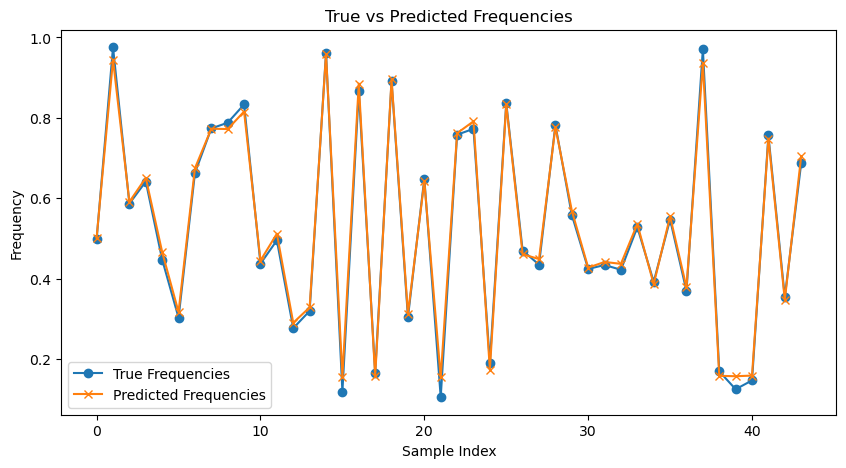

In [10]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="True Frequencies", marker='o')
plt.plot(y_pred_test.numpy(), label="Predicted Frequencies", marker='x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

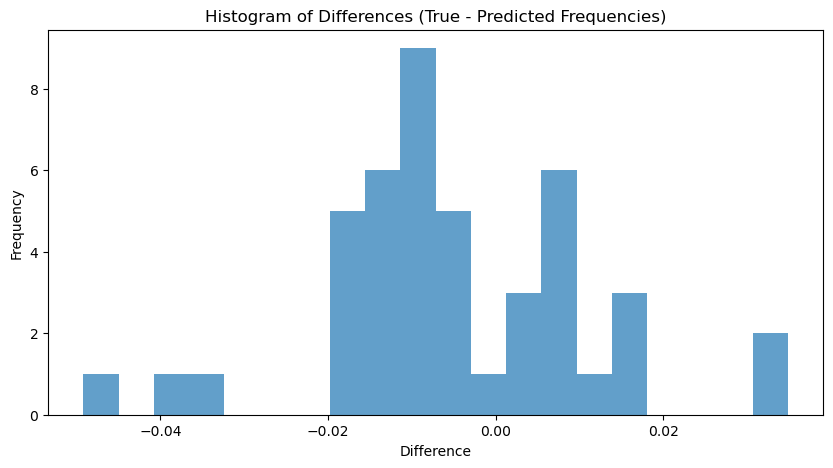

In [11]:
diffs = y_test - y_pred_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(diffs.numpy(), bins=20, alpha=0.7)
plt.title("Histogram of Differences (True - Predicted Frequencies)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show() 

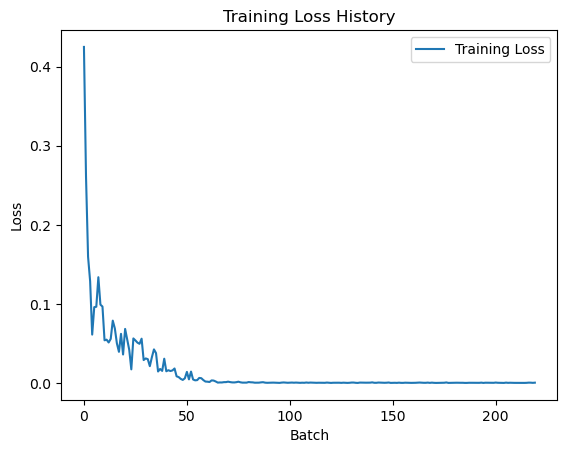

In [12]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [15]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [16]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta_1"].detach().numpy() for i in params_hist])

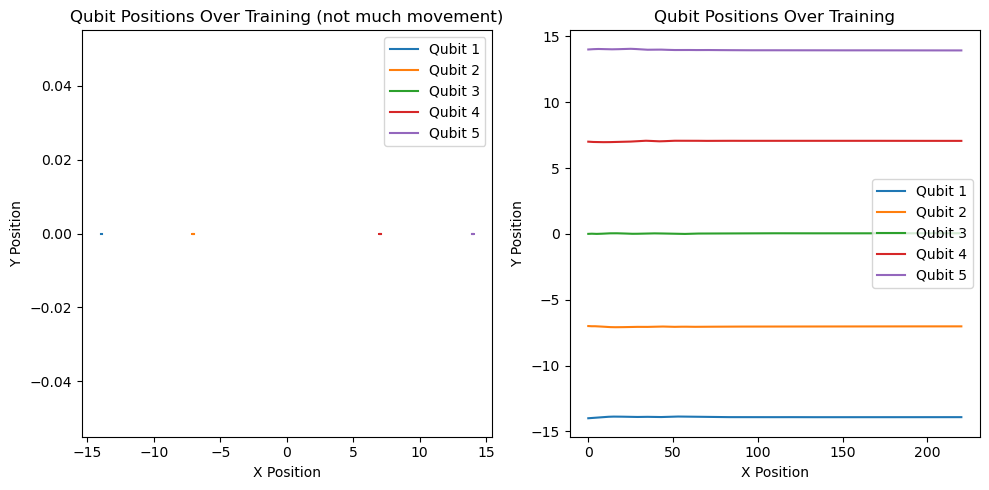

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (not much movement)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], label="Qubit 1")
plt.plot(positions_hist[:, 1, 0], label="Qubit 2")
plt.plot(positions_hist[:, 2, 0], label="Qubit 3")
plt.plot(positions_hist[:, 3, 0], label="Qubit 4")
plt.plot(positions_hist[:, 4, 0], label="Qubit 5")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

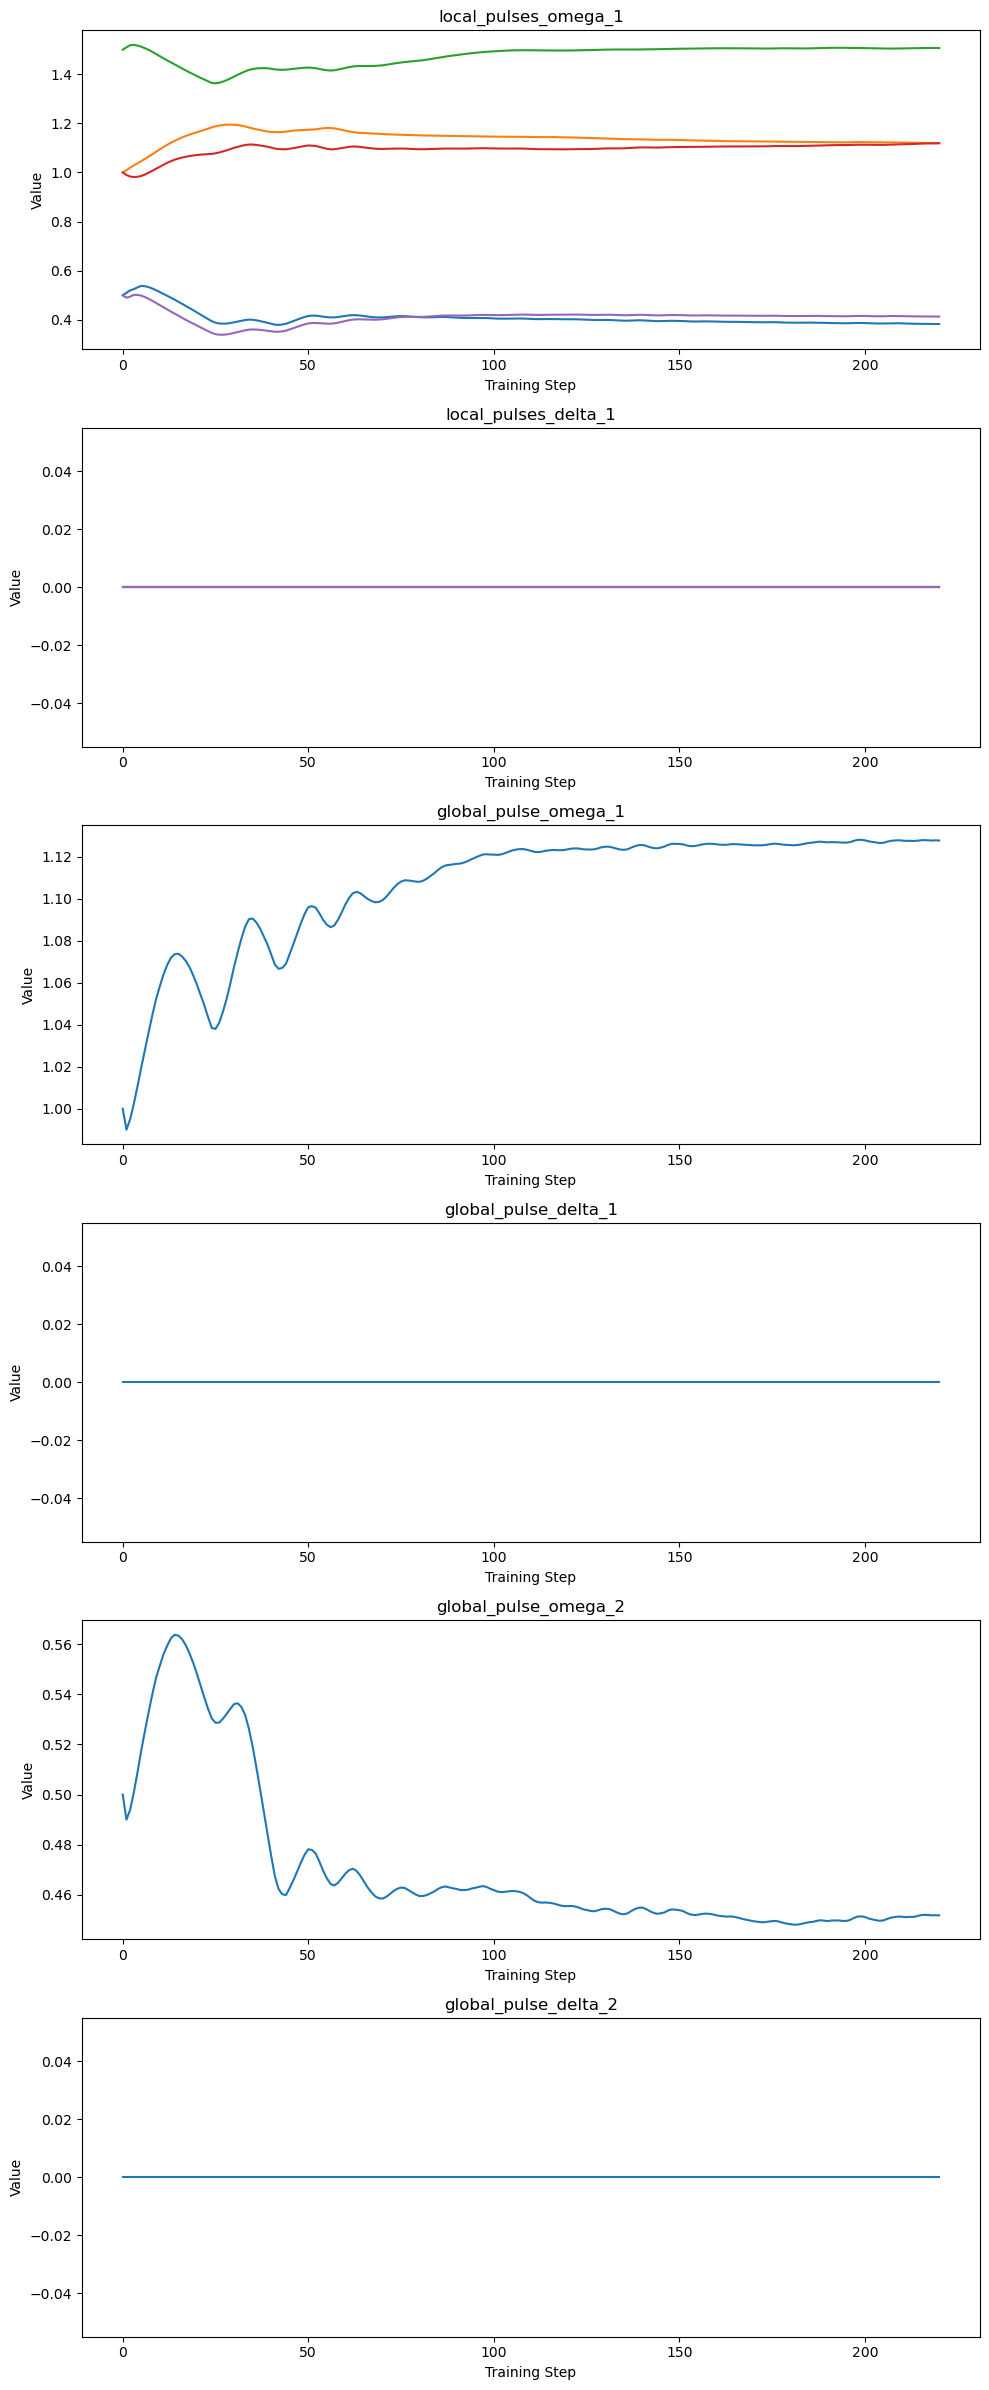

In [18]:
plot_keys = ['local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  